In [1]:
from homework2 import Hw2Env
import torch
import torch.nn as nn
import random
from collections import deque
import json

In [2]:
class DQN(nn.Module):
    def __init__(self, N_actions):
        super().__init__()

        self.lnetwork = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Linear(64, N_actions)
        )
        

    def forward(self, state):
        q_out = self.lnetwork(state)
        return q_out

# Epsilon greedy policy
def get_action(epsilon, main_network : DQN, state):
    rnd = random.random()
    if rnd < epsilon:
        return random.randint(0,7)
    else:
        q_vals = main_network(state.unsqueeze(0))[0]
        act = torch.argmax(q_vals).item()
        return act
        

def update_params(buffer, batch_size, main_network: DQN, target_network: DQN, optimizer, gamma):
    if len(buffer) < batch_size:
        return
    
    batch = random.sample(buffer, batch_size)

    state_tensor = torch.zeros([batch_size, 6], dtype=torch.float32)
    next_state_tensor = torch.zeros([batch_size, 6], dtype=torch.float32)
    action_tensor = torch.zeros(batch_size, dtype=torch.int64)
    reward_tensor = torch.zeros(batch_size, dtype=torch.float32)
    done_tensor = torch.zeros(batch_size, dtype=torch.int64)

    ctr = 0
    for i in batch:
        state_tensor[ctr] = i["state"]
        next_state_tensor[ctr] = i["next_state"]
        action_tensor[ctr] = i["action"]
        reward_tensor[ctr] = i["reward"]
        done_tensor[ctr] = i["done"]
        ctr += 1

    q_out = main_network(state_tensor).gather(1, action_tensor.unsqueeze(1)).squeeze()   

    with torch.no_grad():
        q_target = torch.max(target_network(next_state_tensor),1)[0]
        expected_reward = reward_tensor + gamma * q_target * (1 - done_tensor)

    loss = nn.MSELoss()(q_out, expected_reward)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



def train():

    cumulative_reward_lst = []
    rps_lst = []

    N_ACTIONS = 8

    num_episodes = 10000
    update_frequency = 10
    target_update_frequency = 200
    epsilon = 1
    epsilon_decay = 0.995
    epsilon_min = 0.05
    batch_size=64
    gamma=0.99
    buffer_size=100000
    learning_rate = 0.001

    main_network = DQN(N_ACTIONS).float()
    target_network = DQN(N_ACTIONS).float()
    target_network.load_state_dict(main_network.state_dict())
    target_network.eval()
    main_network.train()

    optimizer = torch.optim.Adam(params=main_network.parameters(), lr=learning_rate)

    buffer = deque(maxlen=buffer_size)

    env = Hw2Env(n_actions=N_ACTIONS, render_mode="offscreen")
    for episode in range(num_episodes):
        env.reset()
        state = torch.tensor(env.high_level_state(), dtype=torch.float32)
        done = False
        cumulative_reward = 0.0
        episode_steps = 0 
          
        while not done:
            action = get_action(epsilon, main_network, state)
            
            _, reward, is_terminal, is_truncated = env.step(action)
            next_state = torch.tensor(env.high_level_state(), dtype=torch.float32)
            done = is_terminal or is_truncated
            buffer.append({"state": state, "action": action,"reward": reward, "next_state": next_state, "done": 1 if done else 0})

            state = next_state    
            cumulative_reward += reward
            episode_steps += 1
            if episode_steps % target_update_frequency == 0: 
                target_network.load_state_dict(main_network.state_dict())
            if episode_steps % update_frequency == 0:
                update_params(buffer, batch_size, main_network, target_network, optimizer, gamma)

        epsilon = max(epsilon_min, epsilon_decay * epsilon)        

        cumulative_reward_lst.append(cumulative_reward)
        rps_lst.append(cumulative_reward/episode_steps)
        print(f"Episode: {episode}, Reward={cumulative_reward}, RPS={cumulative_reward/episode_steps}")

    return main_network, cumulative_reward_lst, rps_lst

def test():
    N_ACTIONS = 8

    network = DQN(N_ACTIONS).float()
    network.load_state_dict(torch.load("./models/model.pth"))
    network.eval()
    env = Hw2Env(n_actions=N_ACTIONS, render_mode="gui")

    env.reset()
    state = torch.tensor(env.high_level_state(), dtype=torch.float32)
    done = False
    cumulative_reward = 0.0
    episode_steps = 0
    while not done:
        action = get_action(0.05, network, state)
        _, reward, is_terminal, is_truncated = env.step(action)
        state = torch.tensor(env.high_level_state(), dtype=torch.float32)
        done = is_terminal or is_truncated
        cumulative_reward += reward
        episode_steps += 1
    print(f"Reward={cumulative_reward}, RPS={cumulative_reward/episode_steps}")



In [3]:
main_network, cumulative_reward_lst, rps_lst = train()

Episode: 0, Reward=2.813219699583228, RPS=0.05626439399166456
Episode: 1, Reward=4.355842286634526, RPS=0.08711684573269052
Episode: 2, Reward=2.3321324073919887, RPS=0.04664264814783978
Episode: 3, Reward=4.113150624124948, RPS=0.08226301248249897
Episode: 4, Reward=2.6442183700095914, RPS=0.052884367400191826
Episode: 5, Reward=8.3433610496402, RPS=0.3476400437350083
Episode: 6, Reward=3.0419351480116013, RPS=0.06083870296023203
Episode: 7, Reward=8.952113291391992, RPS=0.17904226582783983
Episode: 8, Reward=3.434784028998976, RPS=0.06869568057997952
Episode: 9, Reward=3.1793299687837577, RPS=0.06358659937567515
Episode: 10, Reward=4.263085995251906, RPS=0.08526171990503811
Episode: 11, Reward=2.953592173165935, RPS=0.0590718434633187
Episode: 12, Reward=3.5989560023765037, RPS=0.07197912004753007
Episode: 13, Reward=3.0109267786266387, RPS=0.060218535572532775
Episode: 14, Reward=4.098110393463524, RPS=0.08196220786927048
Episode: 15, Reward=4.417484329633275, RPS=0.0883496865926655

In [4]:
main_network.eval()
torch.save(main_network.state_dict(), f"./models/model.pth")

/tmp/ipykernel_4008/3571456615.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


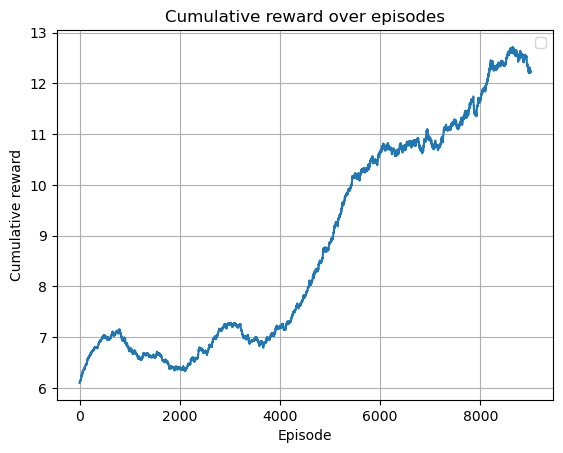

In [5]:
import numpy as np
import matplotlib.pyplot as plt

rwd_data = np.array(cumulative_reward_lst)


window_size = 1000


smoothed_loss = np.convolve(rwd_data, np.ones(window_size)/window_size, mode='valid')
lossX = [i for i in range(len(smoothed_loss))]

plt.plot(lossX, smoothed_loss)
plt.title("Cumulative reward over episodes")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.grid()
plt.legend()
plt.show()

/tmp/ipykernel_4008/2008716809.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


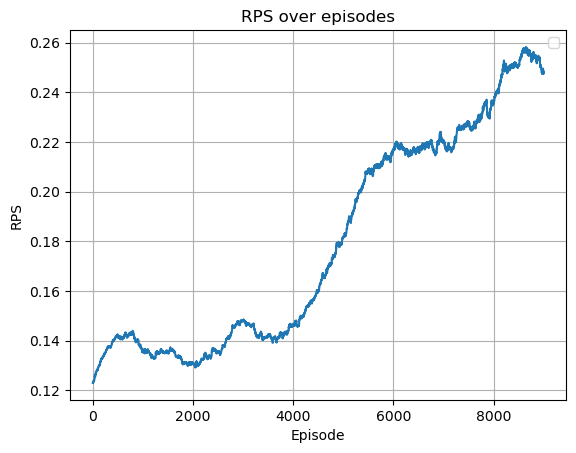

In [6]:

rps_data = np.array(rps_lst)


window_size = 1000


smoothed_loss = np.convolve(rps_data, np.ones(window_size)/window_size, mode='valid')
lossX = [i for i in range(len(smoothed_loss))]

plt.plot(lossX, smoothed_loss)
plt.title("RPS over episodes")
plt.xlabel("Episode")
plt.ylabel("RPS")
plt.grid()
plt.legend()
plt.show()